#### having the return of the industries and return of a portifolio, you can reverse engineering discover in what the manager is investing "moreless"

# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

The code to implement this is a very slight modification of the `minimize_vol` we have previously implemented:

```python                         
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights
```

The Objective function is a very simple one-liner

```python
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
```

In [2]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_ind_file(filetype):
    """
    Load and format the Ken French 30 Industry Portfolios files
    """
    known_types = ["returns", "nfirms", "size"]
    if filetype not in known_types:
        raise ValueError(f"filetype must be one of:{','.join(known_types)}")
    if filetype == "returns":
        name = "vw_rets"
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
                         
    ind = pd.read_csv(f"./data/ind30_m_{name}.csv", header=0, index_col=0)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    return get_ind_file("returns")

In [10]:
ind = get_ind_returns()["2000":]
ind

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,-0.0038,-0.0186,-0.0543,0.0289,-0.0447,0.0254,0.0526,0.0446,0.0001,0.0380,...,0.0295,0.0524,0.0993,-0.0034,0.0291,0.0366,0.0911,0.0364,0.0245,0.0299
2018-09,-0.0032,0.0019,0.0537,-0.0009,-0.0221,0.0107,0.0130,0.0199,-0.0287,-0.0638,...,0.0174,-0.0037,-0.0033,-0.0030,0.0105,-0.0148,0.0061,0.0251,-0.0193,0.0116
2018-10,0.0102,-0.0157,0.0790,-0.1596,-0.0666,-0.0051,-0.1014,-0.0884,-0.1250,-0.2579,...,-0.0050,-0.0920,-0.0806,-0.0982,-0.0975,-0.0788,-0.1021,-0.0171,-0.0545,-0.0599
2018-11,0.0272,0.0579,-0.0843,-0.0065,0.0325,0.0644,-0.0099,0.0632,0.0496,0.0292,...,0.0254,0.0129,-0.0505,0.0822,0.0617,0.0318,0.0159,0.0616,0.0289,0.0348


Constructing a portifolio with 30% beer, 50% smoke and 20% in other things that have an anverage of 0% and annualized vol of 15%


In [11]:
mgr_r = 0.3*ind["Beer"] + .5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

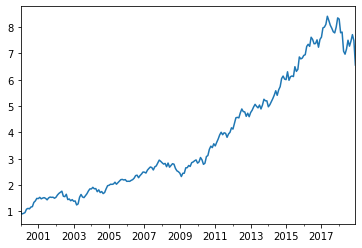

In [16]:
(mgr_r+1).cumprod().plot()

In [26]:
from scipy.optimize import minimize

def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())
                         


In [27]:
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

In [29]:
weights = style_analysis(mgr_r, ind)*100

In [31]:
weights

Food     5.052297e+00
Beer     3.595820e+01
Smoke    4.927169e+01
Games    6.857579e-15
Books    0.000000e+00
Hshld    0.000000e+00
Clths    0.000000e+00
Hlth     4.484935e+00
Chems    1.301043e-15
Txtls    0.000000e+00
Cnstr    5.936007e-15
Steel    0.000000e+00
FabPr    0.000000e+00
ElcEq    1.658829e-15
Autos    5.312938e-17
Carry    0.000000e+00
Mines    3.735076e-15
Coal     2.667137e-15
Oil      6.223320e-15
Util     3.370595e+00
Telcm    6.016655e-01
Servs    2.326294e-01
BusEq    0.000000e+00
Paper    2.732189e-15
Trans    0.000000e+00
Whlsl    0.000000e+00
Rtail    1.027980e+00
Meals    0.000000e+00
Fin      2.656295e-16
Other    2.591243e-15
dtype: float64

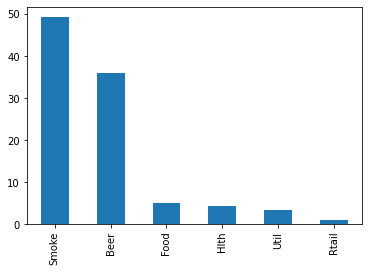

In [33]:
weights.sort_values(ascending = False).head(6).plot.bar()

Contrast this to the results of a regression. Because the model is in fact very true (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. However when it works well, such as in this artificial example here, the results can be very accurate.

In [35]:
import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1
    
    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

In [37]:
coeffs = regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Carry   -3.945878
Hshld   -3.828752
Cnstr   -2.992173
Chems   -2.601602
Whlsl   -2.558225
dtype: float64

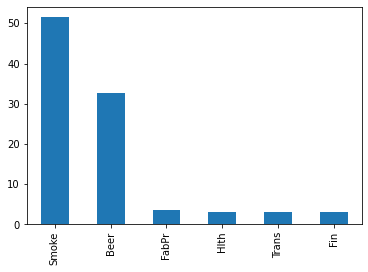

In [38]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

### Style Drift: Time Varying Exposures using Style Anaylsis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

We'll look at Rolling Windows in the next lab session.

As an exercise to the student, download a set of returns from Yahoo Finance, and try and measure the style drift in your favorite fund manager. Use reliable Value and Growth ETFs such as "SPYG" and "SPYV" along with a SmallCap ETF such as "SLY" and LargeCap ETF such as "OEF".

Alternately, the Fama-French research factors and use the Top and Bottom portfolios by Value (HML) and Size (SMB) to categorize mutual funds into categories. This is very similar to the "Style Box" methodology employed by Morningstar and displayed on their website. Compare your results with their results to see if they agree!


### Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [50]:
brka_m = pd.read_csv("./data/brka_m.csv", index_col=0, parse_dates=True).to_period('M')
brka_m

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164
...,...
2018-08,0.047256
2018-09,0.013300
2018-10,-0.038422


In [53]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

.Pergunta 7
